In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set()

In [2]:
plays_df = pd.read_csv("./data/extracted/shot_goal_20161012_20210707.csv")

In [3]:
plays_df.columns

Index(['gameId', 'season', 'gameType', 'dateTime', 'team', 'event',
       'secondaryType', 'description', 'period', 'periodType', 'periodTime',
       'strength', 'emptyNet', 'x', 'y', 'rinkSide', 'distanceToGoal',
       'goalie', 'shooter', 'assist', 'scorer'],
      dtype='object')

In [103]:
def shots_efficiency_by_distance(plays_df: pd.DataFrame, seasons_list : list, save : bool = True, plot : bool = True, path_to_save : str = "./") -> tuple :
    """
    Make graphics of the shot success according to the distance to goal for all seasons passed in parameters

    Args:
        plays_df: Data frame representing plays generated by plays_to_frame
        seasons_list : list of int for the seasons we want to study. For example, season 2019-2020 is represanted by int 20192020
        plot : Boolean to choose to plot or not
        save : Boolean to choose to save the figure
        path_to_save : Path where the figure will be save

    Returns:
        Return a tuple with list of x coordinate and list of y coordinate according to the chosen seasons
    """

    ratio = []
    distinct_distances = []
    for season in seasons_list :
        # Define empty list of ratio of goals 
        ratio_for_season = []

        # Filter dataframe according to the season
        df = plays_df[plays_df["season"] == season]

        # Remove row with nan data in column "distanceToGoal"
        df = df.dropna(subset = ["distanceToGoal"])

        # Change float values into int to deal with constant distances
        df["distanceToGoal"] = (df["distanceToGoal"].astype("int64")).apply(lambda x : 6 * ((x-1) // 6) + 1) # Regroup shot by 10 feet distances
        distinct_distances_for_season = np.unique(df["distanceToGoal"])

        for d in distinct_distances_for_season :
            # Filter dataframe according to distance
            df2 = df[df["distanceToGoal"] == d]

            # Add ratio of goals in ratio list
            ratio_for_season.append(len(df2[df2["event"] == "Goal"])/len(df2) * 100)
        ratio_for_season = np.array(ratio_for_season)
        
        distinct_distances.append(distinct_distances_for_season)
        ratio.append(ratio_for_season)

        if save or plot :
            fig = plt.figure(figsize = [14, 8])
            plt.bar(distinct_distances_for_season, ratio_for_season, width = 5)
            plt.title(f"Pourcentage de tirs réussis en fonction de la distance pour la saison {str(season)[0:4]}-{str(season)[4:8]}")
            plt.xlabel("Distance en feet")
            plt.ylabel("Ratio de tirs réussis")
        if plot :
            plt.show()
        if save :
            fig.savefig(path_to_save + f"shot_efficiency_according_to_distance{str(season)[0:4]}_{str(season)[4:8]}.png")
    return (distinct_distances, ratio)

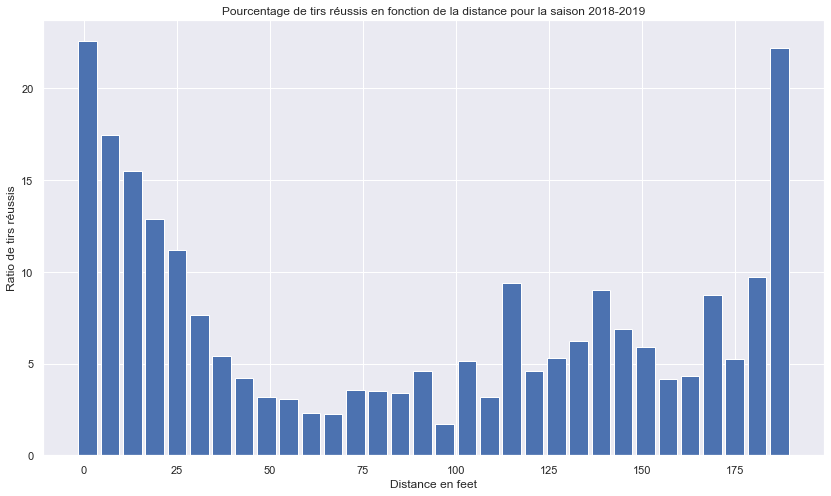

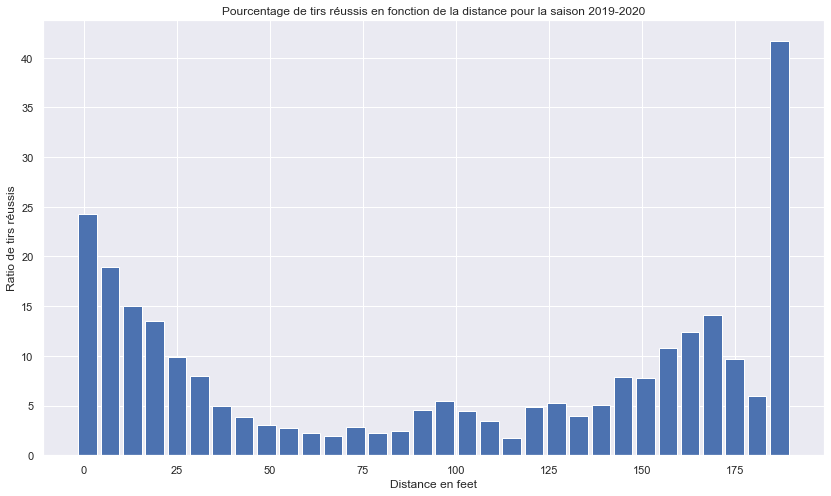

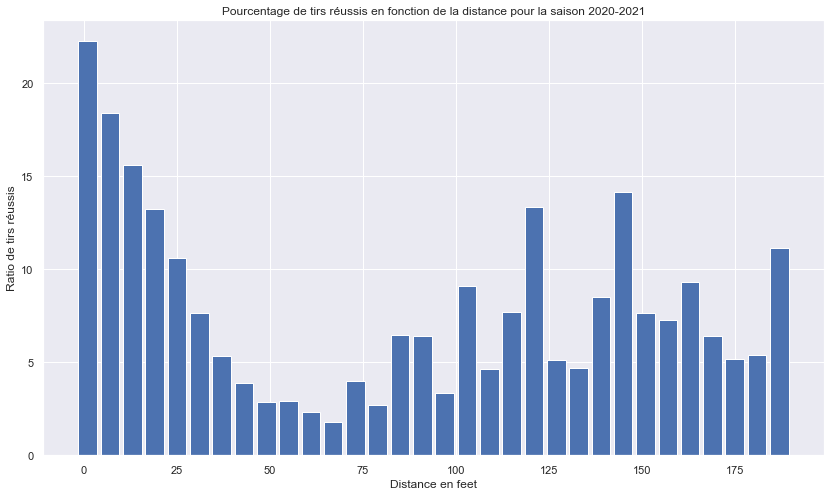

'bla'

In [106]:
seasons_list = [20182019, 20192020, 20202021]
shots_efficiency_by_distance(plays_df, seasons_list, save = False)
"bla"

In [70]:
def shots_efficiency_by_type(plays_df: pd.DataFrame, season : int, save : bool = True, plot : bool = True, path_to_save : str = "./") -> tuple :
    df = plays_df[plays_df["season"] == season]
    df = df.dropna(subset = ["secondaryType"])
    distinct_shot = list(set(df["secondaryType"]))

    Tirs = []
    Buts = []

    for shot in distinct_shot :
        df2 = df[df["secondaryType"] == shot]
        Tirs.append(len(df2))
        Buts.append(len(df2[df2["event"] == "Goal"]))

    X_axis = np.arange(len(distinct_shot))
    width = 0.75
    fig = plt.figure(figsize = [14, 8])
    plt.bar(X_axis, Tirs, width = width,
            color='b', label='Tirs')
    plt.bar(X_axis, Buts, 
            width=0.5*width, color='r', label='Buts')
    for i in X_axis :
        plt.text(i - 2/7, Tirs[i] + 400, str(round(Buts[i]/Tirs[i] * 100, 2)) + "% goal")
    plt.title(f"Nombre de tirs et de buts en fonction du type de tirs pour la saison {str(season)[0:4]}-{str(season)[4:8]}")
    plt.xticks(X_axis, distinct_shot)
    plt.legend()
    if plot :
        plt.show()
    if save :
        fig.savefig(path_to_save + f"shot_efficiency_according_to_type{str(season)[0:4]}_{str(season)[4:8]}.png")
    return (distinct_shot, Tirs, Buts)

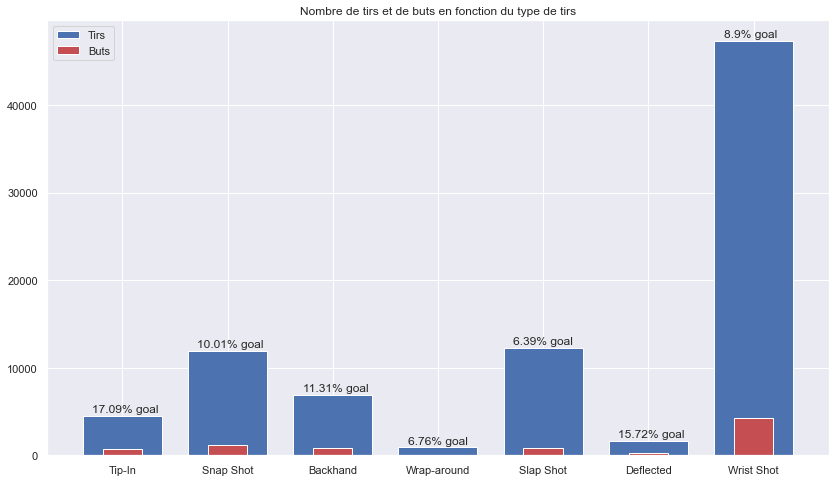

(['Tip-In',
  'Snap Shot',
  'Backhand',
  'Wrap-around',
  'Slap Shot',
  'Deflected',
  'Wrist Shot'],
 [4499, 11917, 6881, 887, 12247, 1679, 47297],
 [769, 1193, 778, 60, 783, 264, 4209])

In [72]:
shots_efficiency_by_type(plays_df, 20182019, save = False)

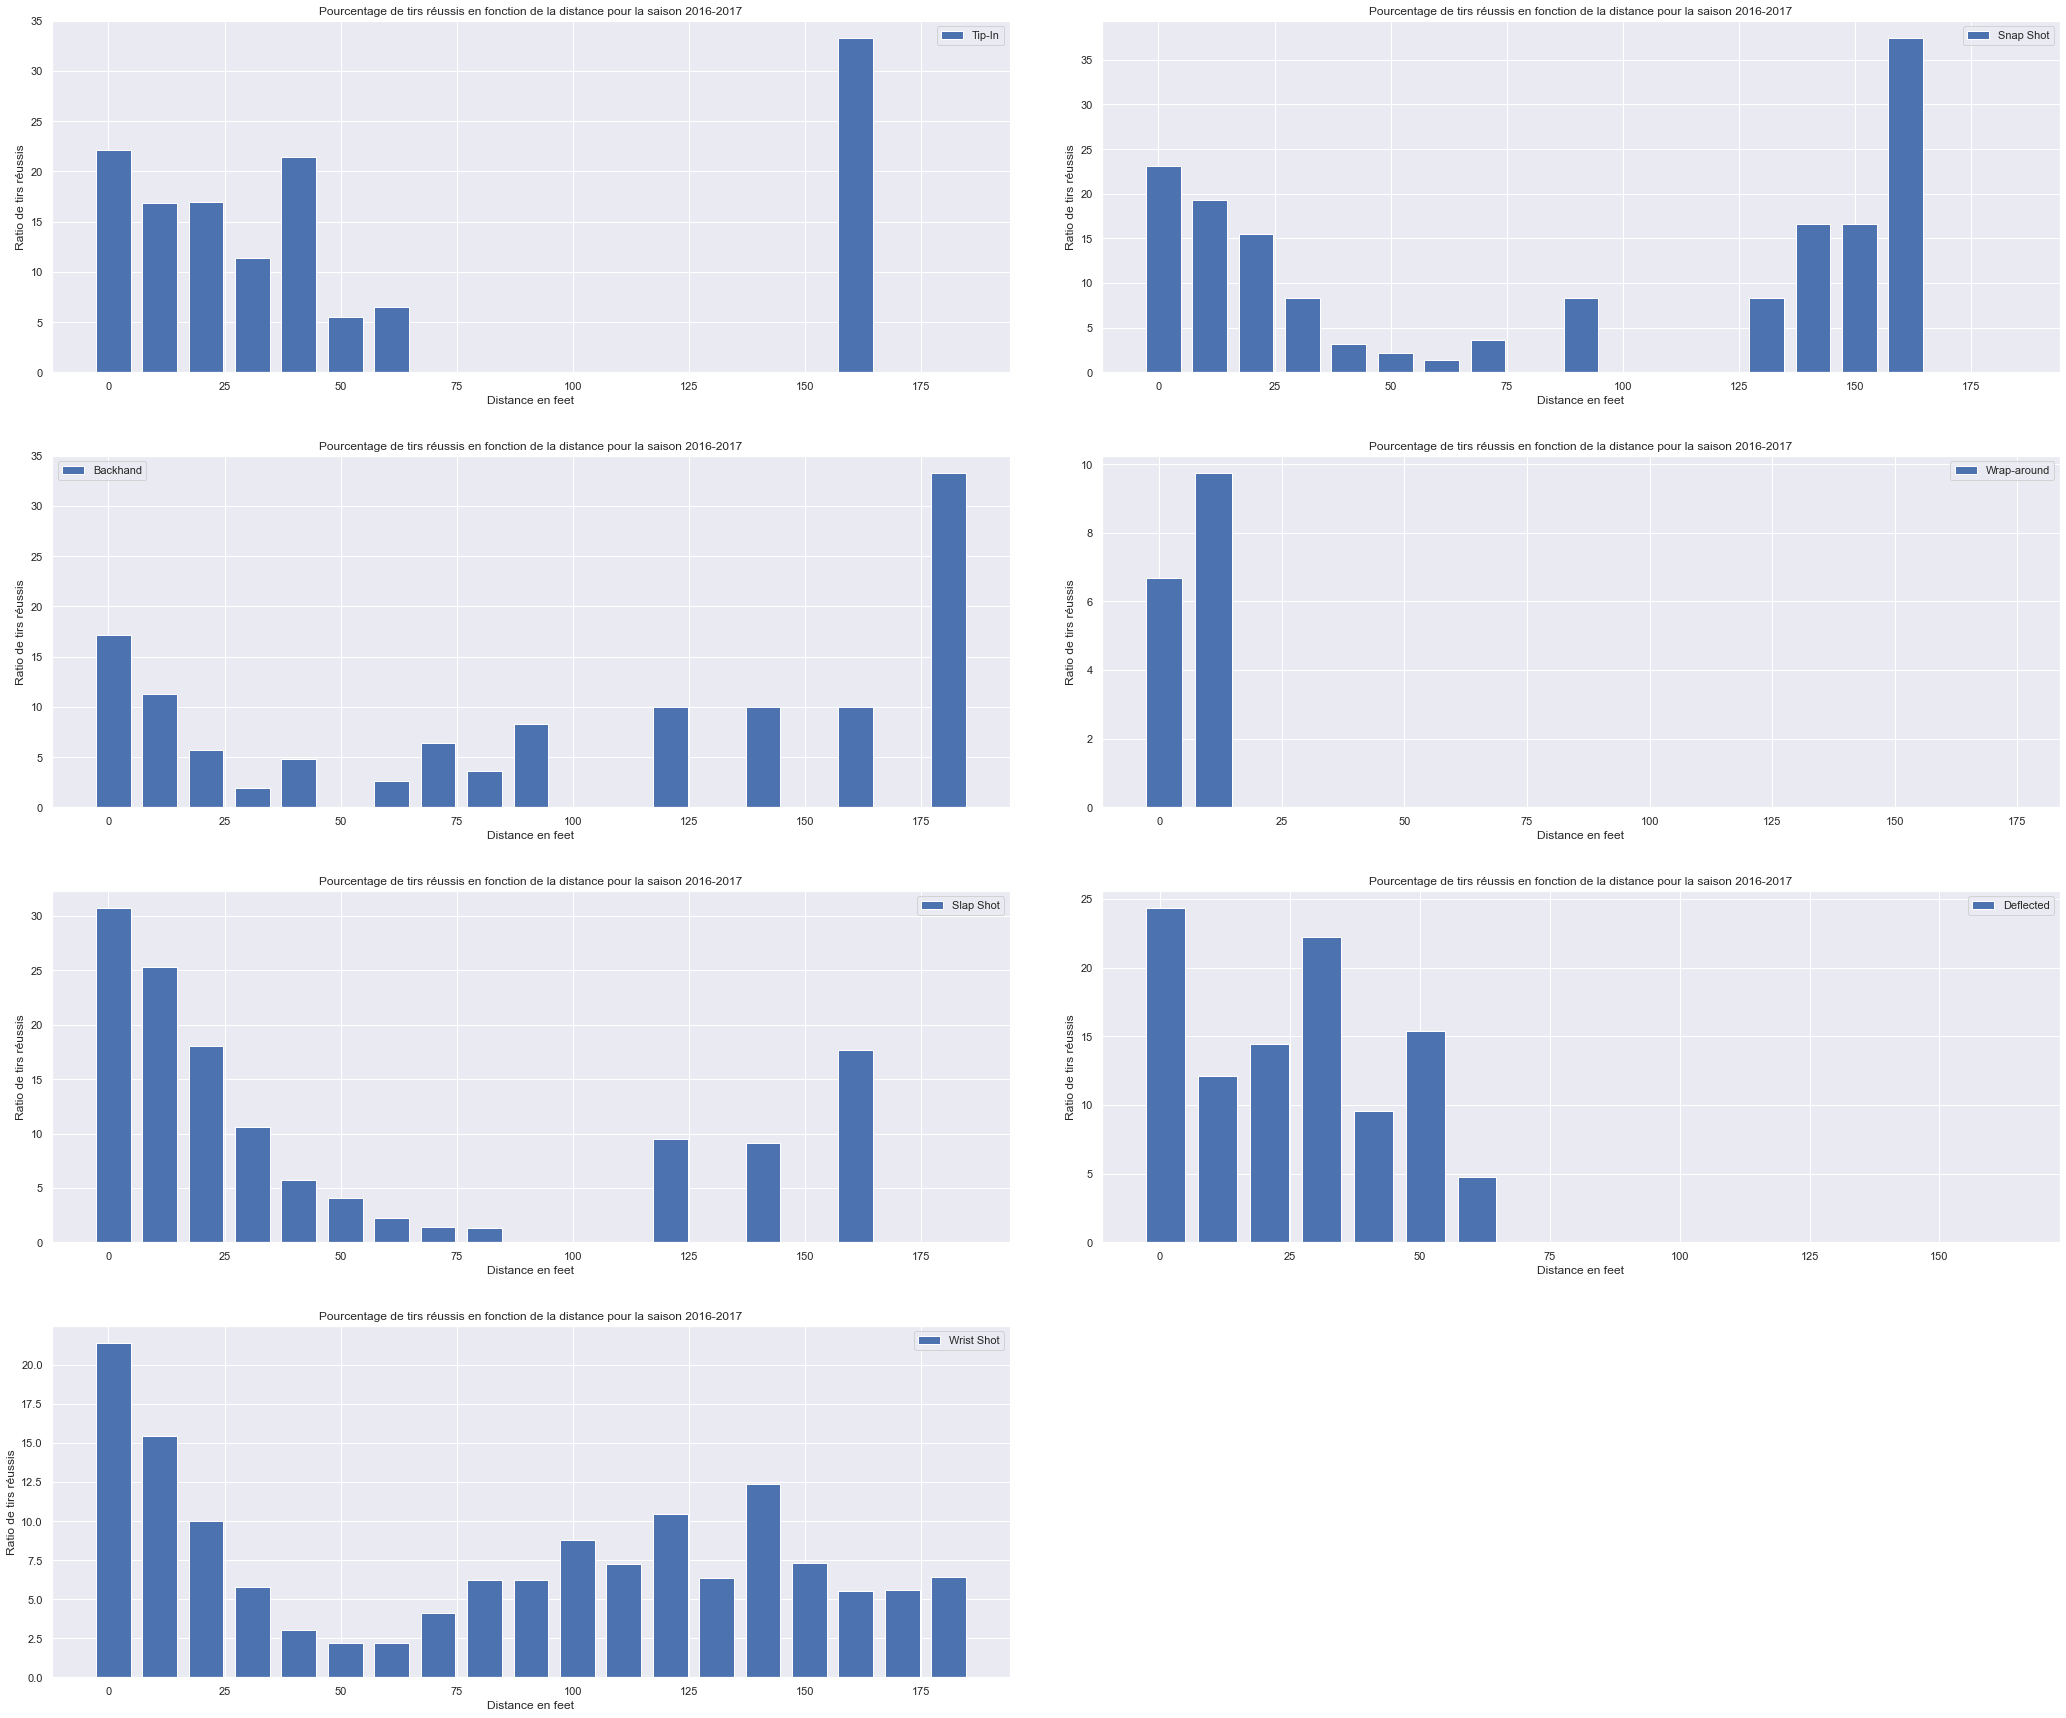

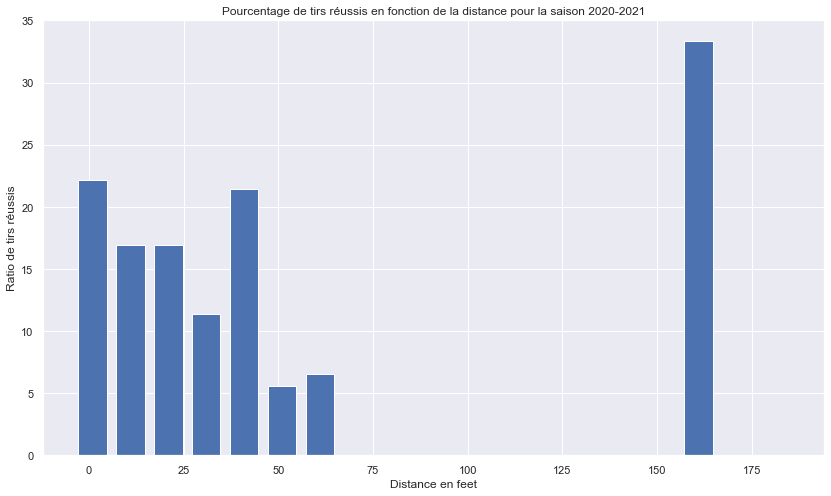

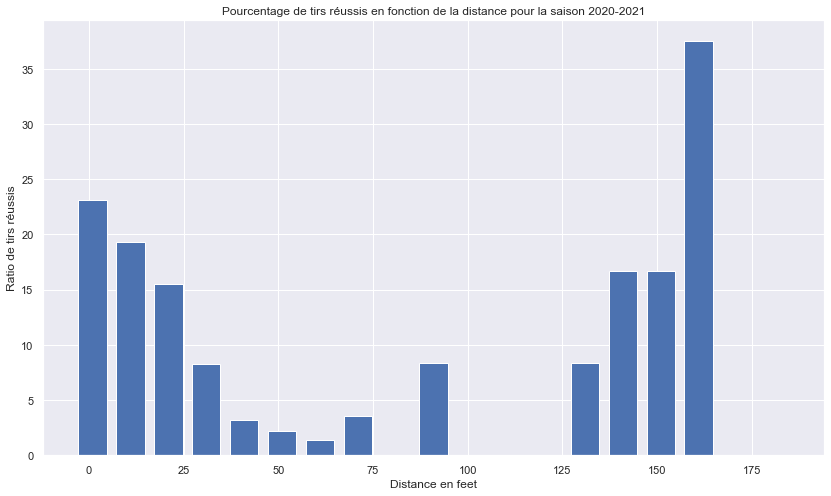

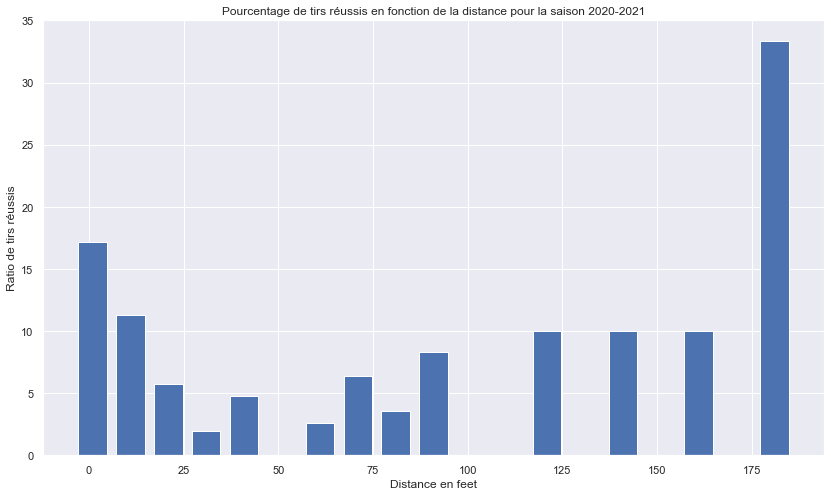

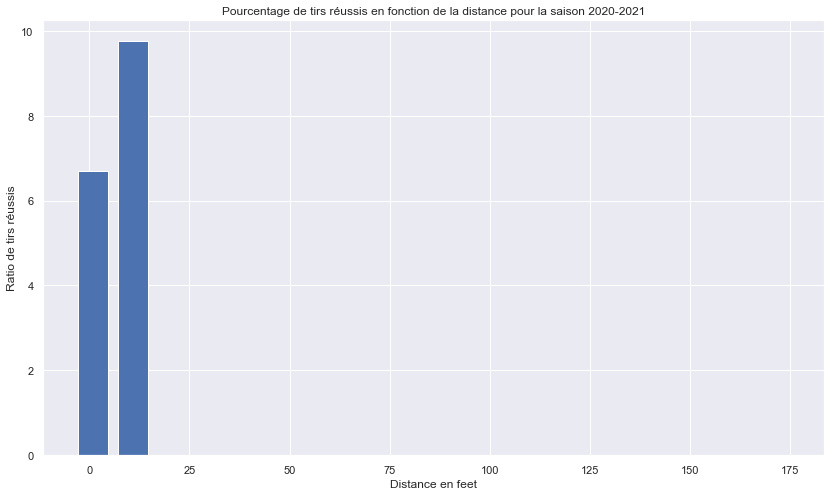

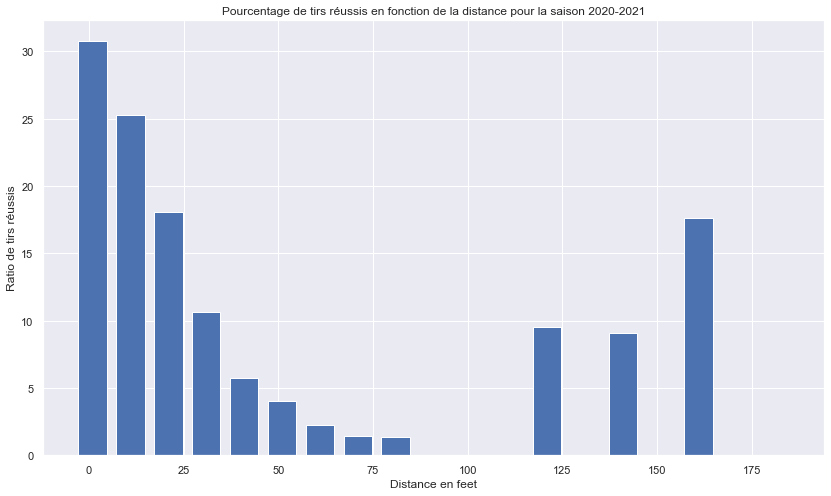

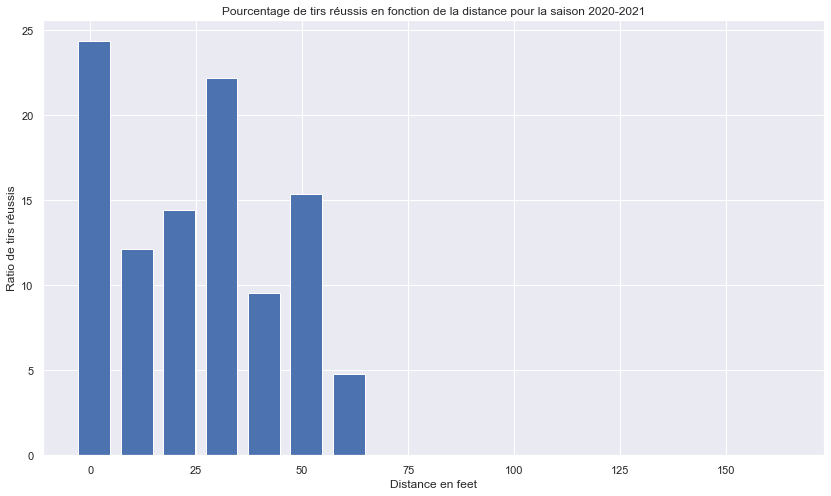

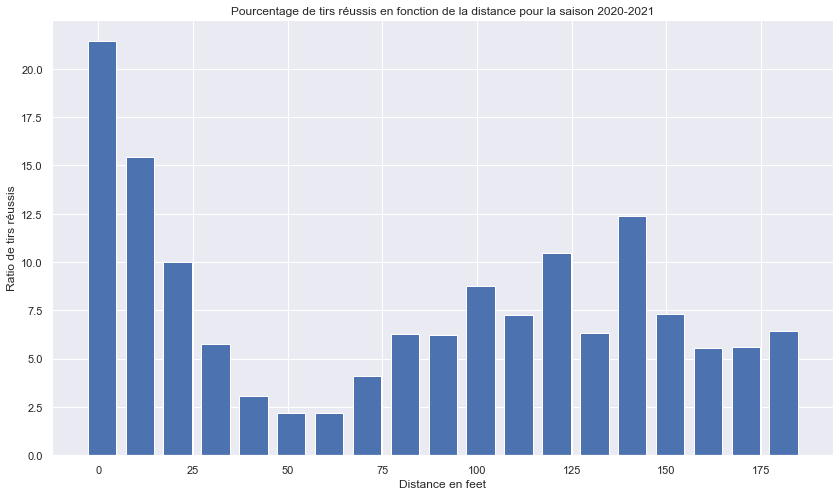

In [89]:
def shots_efficiency_by_type_and_distance(plays_df: pd.DataFrame, season : int, save : bool = True, plot : bool = True, path_to_save : str = "./") -> tuple :
    '''
    Make graphics of the shot efficiency according to the type of shot and the distance to goal, for a season passed in parameter. You can also choose to either plot the figure or not, and to save it. 

    Args : 
        - plays_df : DataFrame obtained by 'play_to_frame' function
        - season : season of your choice (between 2016 and 2021) -> example : 20162017 
        - plot : choose to plot the figure or not
        - path_to_save : path where to save the figure

    Return :
        Return a tuple of x coordinate and y coordinate which represent types, shots and goals
    '''
    # Create subplot with 7 graphics
    fig, ax = plt.subplots(4, 2, figsize=(30,25))
    fig.tight_layout(pad=5.0)
    fig.delaxes(ax[3][1])
    
    # Filter df by season and remove nan values
    df = plays_df[plays_df["season"] == season]
    df = df.dropna(subset = ["distanceToGoal", "secondaryType"])
    distinct_shot = list(set(df["secondaryType"]))
    
    count = 0
    X = []
    Y = []
    
    for shot in distinct_shot :
        # Filter by type of shot
        df2 = df[df["secondaryType"] == shot]
        
        # Use function to have x coordinate and y coordinate for distances and efficiency
        t = distance_shot_relation(df2, [season], save = False, plot = False)
        x = t[0][0]
        y = t[1][0]
        X.append(x)
        Y.append(y)
        
        # Create graphics
        ax[count // 2, count % 2].bar(x, y, label = shot, width = 7.5)
        ax[count // 2, count % 2].title.set_text(f"Pourcentage de tirs réussis en fonction de la distance pour la saison 2016-2017")
        ax[count // 2, count % 2].set_xlabel("Distance en feet")
        ax[count // 2, count % 2].set_ylabel("Ratio de tirs réussis")
        ax[count // 2, count % 2].legend()
        count += 1
     
    #Plot and save the figure (if True)
    if plot :
        plt.show()
    if save :
        fig.savefig(path_to_save + f"shot_efficiency_according_to_type_and_distance{str(season)[0:4]}_{str(season)[4:8]}.png")
    return (X, Y)